# Tarea 3 Cadenas de Markov


Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación de algunos resultados vistos en clase para el Gibbs Sampler aplicado a Hard-core y q-colorings. 

Las librerías necesarias para ejectuar el código son:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pprint import pprint

# Modelo de Ising  usando MCMC y Algoritmo de Propp - Wilson

### Muestras del modelo de Ising con inverso de temperatura usando MCMC

Iniciamos creando la grilla del módelo. Para esto, creamos una matriz $kxk$ de dimensión 2, apoyándonos en la libreria Numpy. Las dimensiones del grafo cumplen $10\leq k \leq 20$.

Por otro lado, la energía del modelo, bajo campo libre y sin interacciones de orden superior, viene dada por el Hamiltoniano $H(\eta)$, que se expresa como:

$$H(\eta)=-\sum_{x\thicksim y}\eta_{x}\eta_{y}$$

D0onde $\eta$ es la configuracion actual del sistema y $\eta_{x}$, $\eta_{y}$ son la posicion de dos nodos de $\eta$ tal que $x$ y $y$ estan conectados.

Con esto en mente creamos una funcion que calcula la energia del sistema dada una configuracion $\eta$ del modelo.

In [2]:
def calcular_energia(G):
    """
    Calcula la energia de la configuracion dada. Primero se suman enlaces horizontales, luego verticales
    """ 
    energia = 0
    k = len(G)
    
    ## Suma sobre enlaces horizontales
    for ii in range(k):
        for jj in range(k-1):
            energia += G[ii,jj] * G[ii,jj+1]
            
    ## Suma sobre enlaces verticales
    for ii in range(k-1):
        for jj in range(k):
            energia += G[ii,jj] * G[ii+1,jj]

    return -1 * energia


G = np.random.choice([-1, 1], size=(4, 4))
print("Grilla del modelo de Ising:")
print(G)

Grilla del modelo de Ising:
[[-1 -1 -1 -1]
 [ 1 -1  1 -1]
 [-1  1  1 -1]
 [-1 -1  1  1]]


Ahora usemos un Gibbs sampler para implementar el método de Montecarlo en nuestro problema. Este funcionará de la siguiente manera:

- Seleccione un vertice al azar $\~{x}$ de la configuración actual $\eta$.
- Cambie el valor del vertice escogido. Con esto se obtiene una nueva configuración $\hat{\eta}$ del sistema.
- Calcule la diferencia de energía de la configuración $\eta$.
- Calcule la probabilidad de cambio de $\eta$ utilizando la probabilidad de distribución del vértice $\~{x}$: 

$$ \Delta \pi = \frac{\exp^{2\beta (k_{+}(\~x, \eta)-k_{-}(\~x, \eta))}}{\exp^{2\beta (k_{+}(\~x, \eta)-k_{-}(\~x, \eta))} + 1} $$

- Genere un numero aleatorio uniforme $u$ entre 0 y 1
- Si $u < \Delta \pi$, acepta la nueva configuracion. Si no, mantenemos con la configuracion $\eta$.
- Repetimos el algoritmo hasta completar el número de iteraciones propuestas.

Note que el calculo de la energía deja de aparecer directamenete en el algoritmo, y aparece la diferencia entre la acumulación de cargas positivas y negativas alrededor de un vertice dado.

A continuación, creamos una nueva función para el cálculo de esta acumulación y otra para la probabiliadad de cambio:

In [3]:
def calcular_factor(G, x, y):
    """
    Calcula la diferencia de la energia al cambiar el valor de spín en un nodo (electrón) dado
    """
    energia = 0
    k = len(G)
    
    if x != 0:
        energia += G[x-1, y]
    if x != k-1:
        energia += G[x+1, y]
    if y != 0:
        energia += G[x, y-1]
    if y != k-1:
        energia += G[x, y+1]
    return energia


def calcular_probabilidad(beta, factor):
    """
    Calcula la probabilidad de cambio de la nueva configuración
    """
    e = np.exp(2 * beta * factor)
    return e / (e+1)

Y con esto creamos el Gibbs sampler para nuestro modelo:

In [4]:
def gibbs_sampler_mcmc(G, beta, iteraciones):
    
    k = len(G)
    
    for _ in range(iteraciones):
        
        # Selecciona spin aleatorio
        x = random.randint(0, k-1)
        y = random.randint(0, k-1)

        # Calcula la energia de la configuracion actual y siguiente segun el spin dado
        diferencia_energia = calcular_factor(G, x, y)
        
        # Halla la probabilidad de transición
        prob_cambio = calcular_probabilidad(beta, diferencia_energia)

        # Decidir si hacer o no transición
        if np.random.rand() < prob_cambio:
            G[x, y] = 1 
        else: 
            G[x, y] = -1
    
    return G

Ahora solo nos queda probar el algoritmo con los valores de beta y pasos del gibbs sampler que definimos al inicio para obtener el numero de muestras deseadas.

Adicionalmente, creamos una lista con los $\beta$ que vamos a evaluar y otra con los diferentes números de pasos con los que ejecturemos el algoritmo. Adicional a los $\beta$ sugeridos, vamos a incluir $\beta _c$, el parámetro crítico de Onsager.

In [5]:
onsager_critical_value = 0.5 * np.log(1 + np.sqrt(2))

k = 10
beta_list_mcmcm = [0, 0.1, 0.2, 0.3, 0.4, onsager_critical_value, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
steps_list = [10**3, 10**4, 10**5]
n_muestras = 100



configuraciones_mcmc = {}

# Loop principal
for step in steps_list: # Iterar sobre los posibles números de pasos
    
    configuraciones_mcmc[step] = {key: [] for key in beta_list_mcmcm}
    
    for beta in beta_list_mcmcm: # Iterar sobre los posibles beta
    
        for _ in range(n_muestras): # Numero de muestras a guardar
            G = np.random.choice([-1, 1], size=(k, k))  # Configuración inicial aleatoria
            configuraciones_mcmc[step][beta].append(gibbs_sampler_mcmc(G, beta, step).copy())  # Guarda la configuracion final
        print(f"Guardado {n_muestras} muestras con X = {step} para beta = {beta}")

Guardado 100 muestras con X = 1000 para beta = 0
Guardado 100 muestras con X = 1000 para beta = 0.1
Guardado 100 muestras con X = 1000 para beta = 0.2
Guardado 100 muestras con X = 1000 para beta = 0.3
Guardado 100 muestras con X = 1000 para beta = 0.4
Guardado 100 muestras con X = 1000 para beta = 0.44068679350977147
Guardado 100 muestras con X = 1000 para beta = 0.5
Guardado 100 muestras con X = 1000 para beta = 0.6
Guardado 100 muestras con X = 1000 para beta = 0.7
Guardado 100 muestras con X = 1000 para beta = 0.8
Guardado 100 muestras con X = 1000 para beta = 0.9
Guardado 100 muestras con X = 1000 para beta = 1
Guardado 100 muestras con X = 10000 para beta = 0
Guardado 100 muestras con X = 10000 para beta = 0.1
Guardado 100 muestras con X = 10000 para beta = 0.2
Guardado 100 muestras con X = 10000 para beta = 0.3
Guardado 100 muestras con X = 10000 para beta = 0.4
Guardado 100 muestras con X = 10000 para beta = 0.44068679350977147
Guardado 100 muestras con X = 10000 para beta = 0.

Notamos que, en términos de tiempo de cómputo, el Gibss sampler tiene tiempo constante para todo $\beta$, y escala linealmente con el valor del número de pasos. Esto hace que hacer muestreo del sistema en equilibrio sea demorado, pues se hace necesario un gran número de pasos 

In [6]:
print("\nVisualizacion de algunas de las configuraciones de las muestras:\n")
print("Beta = 0")
pprint(configuraciones_mcmc[100000][0][3])

print()
print("Beta = 1")
pprint(configuraciones_mcmc[100000][1][2])


Visualizacion de algunas de las configuraciones de las muestras:

Beta = 0
array([[-1,  1, -1,  1, -1,  1,  1, -1, -1, -1],
       [-1,  1,  1, -1, -1,  1,  1, -1,  1,  1],
       [ 1, -1, -1,  1,  1, -1,  1, -1,  1, -1],
       [-1, -1, -1, -1,  1, -1,  1,  1,  1, -1],
       [ 1, -1,  1,  1, -1, -1,  1,  1,  1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1,  1,  1],
       [ 1,  1, -1, -1,  1,  1,  1,  1, -1,  1],
       [ 1,  1,  1, -1,  1, -1,  1, -1, -1, -1],
       [-1, -1,  1, -1, -1, -1, -1,  1,  1,  1],
       [-1, -1, -1,  1, -1, -1, -1, -1, -1, -1]])

Beta = 1
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


Cuando imprimimos algunas de estas configuraciones, vemos que:

- Para $\beta = 0$ (altas temperaturas), la organización de spins parece ser de tipo i.i.d.: aproximadamente la mitad está en estado +1, y otra mitad en estado -1, sin ningún tipo de preferencia espacial.
- Para $\beta = 1$ (bajas temperaturas), la organización de spins es a) todos en estado +1, o b) todos en estado -1.

Esto está de acuerdo con lo predicho por la teoría.

---
### Muestras del modelo de Ising con inverso de temperatura usando Prop-Wilson

Usaremos los mismos valores tomados anteriormente para hacer una comparación mas adelante entre las muestras obtenidas con el algoritmo de de Propp-Wilson y MCMC.

Las funciones de acumulación y probabilidad son las mismas, aquí cambia el método de aplicar el Gibbs sampler. Usaremos sadwiching para la implementacion de el algoritmo de Propp-Wilson sobre las cofiguraciones $\eta_{min}$ (Todos -1) y $\eta_{max}$ (Todos 1). Y para esto, nos hace falta:

- Una secuencia creciente de números enteros positivos: $\; N = \{N_{1}, N_{2}, ... \}$.
- Una secuencia de números aleatorios uniformemente distribuidos en $[0, 1]$: $\; U = \{U_{0}, U_{-1}, ... \}$.
- Dos secuencias de coordenadas aleatorias uniformemente distribuidos en $[0, k-1]$: $\; \hat{U} = \{ \hat{U}_{0}, \hat{U}_{-1}, ... \}\;$ y $ \; \hat{U} = \{ \hat{U}^{'}_{0}, \hat{U}^{'}_{-1}, ... \}$.

La secuencia $N$ nos servira para seleccionar los elementos de las sucesiones aleatorias. Tomaremos $N_{n} = 2^{n}$. 

La secuencia $U$ dicatará los valores a comparar con las probabilidades de cambio de los sistemas $\eta_{min}$ y $\eta_{max}$. 

Las secuencias $\hat{U}$ y $\hat{U'}$ serán las encargadas de seleccionar las cordenadas $\hat{x}$, $\hat{y}$ de los vértices a evaluar.

Para esto, creemos la siguiente clase:


In [7]:
class Random_sequence:
    def __init__(self, k):
        self.k = k
        self.N = 0 # indice de la sucesion de numeros creciente (N)
        self.U_float = np.zeros((0,), dtype=float)
        self.U_int = np.zeros((0,2), dtype=int)

    def update_random(self, next_N):
        self.U_float.resize((next_N,))
        self.U_int.resize((next_N,2))
        self.U_float[self.N:] = np.random.random((next_N - self.N,))
        self.U_int[self.N:] = np.random.randint(0, self.k, size=(next_N - self.N,2))
        self.N = next_N

Esta clase funciona nos asegura generar números aleatorios nuevos en cada paso del Gibbs sampler y seleccionar los correspondientes según la secuencia dada. Además, estos valores se guardan en los arreglos creados y nos permiten ver el registro historico de elementos aleatorios seleccionados.


Ahora podemos crear nuestro Gibbs Sampler usando Propp-Wilson:

In [8]:
def gibbs_sampler_pw(k, beta):

    N = 1 # indice de la sucesion de numeros creciente
    rand_sequence = Random_sequence(k) # Clase de generacion y memoria de numeros aleatorios usados
    rand_sequence.update_random(N) # genera primeros numeros aleatorios

    #coalecencia
    coales_time = 0

    # Configuraciones extremas
    G_max = np.ones((k, k))
    G_min = -np.ones((k, k))

    while True:
        
        top_size = rand_sequence.U_float.size
        
        for i in range(top_size):
            coales_time += 1
            m = top_size - i - 1 # indice de la secuencia aleatoria

            x = rand_sequence.U_int[m, 0] # Numero aleatorio dado por la secuencia de enteros
            y = rand_sequence.U_int[m, 1] # Numero aleatorio dado por la secuencia de enteros

            # Sandwiching

            delta_energia_min = calcular_factor(G_min, x, y)
            delta_energia_max = calcular_factor(G_max, x, y)

            prob_cambio_max = calcular_probabilidad(beta, delta_energia_max)
            prob_cambio_min = calcular_probabilidad(beta, delta_energia_min)

            rand_to_prob = rand_sequence.U_float[m] # Numero aleatorio dado por la secuencia de flotantes

            # Condicion de Cambio G1\n",
            if rand_to_prob < prob_cambio_max:
                G_max[x, y] = 1 
            else: 
                G_max[x, y] = -1

            # Condicion de Cambio G2\n",
            if rand_to_prob < prob_cambio_min:
                G_min[x, y] = 1 
            else:
                G_min[x, y] = -1 

        # Verifica coalecencia\n",
        if np.array_equal(G_min, G_max):
            return G_min, coales_time
        else:
            N = max(N+1, N*2) # sucesion de potencias de 2
            rand_sequence.update_random(N) # genera nuevos numeros aleatorios


Ahora generamos las muestras deseadas con los valores de beta dados. 

Es necesario notar que, según la nota 43 del capítulo 11 del libro de Haggstrom, el tiempo de simulación para el algoritmo de Prop-Wilson aumenta exponencialmente para valores de Beta crítico que superen el valor crítico de Onsager $\beta_c = \frac{1}{2}\log(1 + \sqrt{2}) \approx 0.441$. Por esta razón, solo vamos tomar muestras con este algoritmo para valores de $\beta \le 0.6$. Experimentalmente intentamos hallar muestras para valores $\beta > 0.6$, pero con $\beta = 0.6$ el tiempo de ejecución fue enorme.

- $\beta = 0.1, 0.2, 0.3, 0.4$ se simulan en cuestión de pocos segundos.
- $\beta = 0.5$ se simula en cuestión de $\approx 45$ segundos.
- $\beta = 0.6$ tomó 23 minutos.

Teniendo en cuenta el aumento exponencial mencionado en el libro, no pudimos seguir simulando.

In [9]:
configuraciones_pw = {}
tiempos_coalescencia = {}

k = 10
beta_list_pw = [0, 0.1, 0.2, 0.3, 0.4, onsager_critical_value, 0.5, 0.6]
n_muestras = 100


# Loop principal\n",
for beta in beta_list_pw: # Beta a utilizar
    configuraciones_pw[beta] = []
    tiempos_coalescencia[beta] = []
    for _ in range(n_muestras): # Numero de muestras a guardar
        data = gibbs_sampler_pw(k, beta)
        configuraciones_pw[beta].append(data[0].copy())  # Guarda la configuracion final
        tiempos_coalescencia[beta].append(data[1])  # Guarda el tiempo de coalecencia
    print(f"Guardado {n_muestras} muestras para beta = {beta}")

Guardado 100 muestras para beta = 0
Guardado 100 muestras para beta = 0.1
Guardado 100 muestras para beta = 0.2
Guardado 100 muestras para beta = 0.3
Guardado 100 muestras para beta = 0.4
Guardado 100 muestras para beta = 0.44068679350977147
Guardado 100 muestras para beta = 0.5
Guardado 100 muestras para beta = 0.6


Notamos que, en términos de tiempo de cómputo, Propp-Wilson es extremadamente eficiente siempre que $\beta \le \beta _c$. Una vez se pasa este umbral, el tiempo de cómputo aumenta enormemente, y para $\beta$ muy grande, Propp-Wilson se vuelve un algoritmo muy ineficiente. Por lo tanto, es situaciones reales, lo ideal sería usar Propp-Wilson para $\beta \le \beta _c$, y a partir de este punto empezar a usar el algoritmo de Monte Carlo descrito anteriormente

### Estimacion valor esperado de magnetización en modelo de Ising

Con las muestras que tenemos, vamos a comparar la magnetización del sistema para las muestras generadas con MCMCM y Propp-Wilson. 
 
Para esto, primero tenemos que calcular la magnetización de cada una de las muestras encontradas. Para esto, usamos la fórmula:

$$M(\eta) =  \left| \frac{1}{|V_{k}|}\sum_{x \in V_{k}} \eta_{x} \right|$$

En nuestro caso tenemos $|V_{k}| = k^{2}$.

Por otra parte, el valor absoluto se añade por una cuestión física. Suponga que se tienen 3 configuraciones con las siguientes características:

1. Todos los spins hacia arriba (+1).
2. Todos los sipins hacia abajo (-1).
3. De forma aleatoria y desordenada, la mitad de los spins están hacia arriba (+1), y la otra mitad hacia abajo (-1).

El tercer caso representa un sistema completamente desmagnetizado, pues los spins no siguen ningún patrón coherente. Por su parte, las dos primeras configuraciones representan un estado con alta magnetización, dado que los spins se encuentran perfectamente ordenados. 

Esto justifica la existencia del valor esperado, pues tiene en cuenta la simetría física del sistema presente entre la configuración 1. y 2. 

Finalmente, otro argumento físico a favor de esta valor absoluto es el comportamiento del sistema visto anteriormente para distintos valores de $\beta$:

- Para $\beta = 0$ (altas temperaturas), la organización de spins parece ser de tipo i.i.d.: aproximadamente la mitad está en estado +1, y otra mitad en estado -1, sin ningún tipo de preferencia espacial.
- Para $\beta = 1$ (bajas temperaturas), la organización de spins es a) todos en estado +1, o b) todos en estado -1.


Así, tenemos la siguiente función:

In [10]:
def calcular_magnetizacion(k, configuraciones, beta_list):
    magnetizacion_list = {}
    for beta in beta_list:
        magnetizacion_list[beta] = []
        for config in configuraciones[beta]:
            magnetizacion_list[beta].append(abs(np.sum(config)/(k**2)))
    return magnetizacion_list

magnetismo_mcmc_list = {} # Lista por numero de pasos de magnetizacion en muestras de MCMC
for step in steps_list:
    magnetismo_mcmc_list[step] = calcular_magnetizacion(k, configuraciones_mcmc[step], beta_list_mcmcm) # Magnetizacion muestras MCMCM
    print(f"Hallada la magnetizacion de MCMCM para step {step}")

magnetismo_pw = calcular_magnetizacion(k, configuraciones_pw, beta_list_pw) # Magnetizacion muestras Prop-Wilson
print(f"Hallada la magnetizacion de Propp-Wilson")

Hallada la magnetizacion de MCMCM para step 1000
Hallada la magnetizacion de MCMCM para step 10000
Hallada la magnetizacion de MCMCM para step 100000
Hallada la magnetizacion de Propp-Wilson


Ahora calculamos el valor esperado de la magnetización para configuración mediante la siguiente expresión:

$$E[M(\eta)] \approx \frac{1}{X} \sum_{k=1}^{X}M(\eta_{k})$$

donde $X$ es el numero de muestras, que en nuestro caso es $100$. Así, definimos la siguiente función:

In [11]:
def valor_esperado(magnetismo, beta_list):
    vesperado_list = {}
    for beta in beta_list:
        vesperado_list[beta] = np.average(magnetismo[beta])
    
    return vesperado_list

vesperado_mcmc_list = {} # Lista por numero de pasos de valor esperado en mustras de mcmc
for step in steps_list:
    vesperado_mcmc_list[step] = valor_esperado(magnetismo_mcmc_list[step], beta_list_mcmcm) # Valor esperado de magnetizacion en MCMC


vesperado_pw = valor_esperado(magnetismo_pw, beta_list_pw) # Valor esperado de magnetizacion en P-W

for step in steps_list:
    print(f"Valor esperado usando MCMC con X = {step}:")
    pprint(vesperado_mcmc_list[step])
    print()

print("Valor esperado usando PW: ")
pprint(vesperado_pw)


Valor esperado usando MCMC con X = 1000:
{0: 0.08559999999999998,
 0.1: 0.0928,
 0.2: 0.1326,
 0.3: 0.17699999999999996,
 0.4: 0.262,
 0.44068679350977147: 0.28,
 0.5: 0.32480000000000003,
 0.6: 0.412,
 0.7: 0.3889999999999999,
 0.8: 0.4166,
 0.9: 0.4224,
 1: 0.4278}

Valor esperado usando MCMC con X = 10000:
{0: 0.0748,
 0.1: 0.09659999999999998,
 0.2: 0.12200000000000001,
 0.3: 0.18580000000000002,
 0.4: 0.32500000000000007,
 0.44068679350977147: 0.3986,
 0.5: 0.6322000000000001,
 0.6: 0.7806000000000001,
 0.7: 0.85,
 0.8: 0.8930000000000001,
 0.9: 0.8850000000000001,
 1: 0.8504}

Valor esperado usando MCMC con X = 100000:
{0: 0.0814,
 0.1: 0.1026,
 0.2: 0.12420000000000002,
 0.3: 0.19,
 0.4: 0.2846,
 0.44068679350977147: 0.48840000000000006,
 0.5: 0.6448,
 0.6: 0.8825999999999999,
 0.7: 0.9539999999999997,
 0.8: 0.9808000000000001,
 0.9: 0.9914000000000001,
 1: 0.9948}

Valor esperado usando PW: 
{0: 0.09119999999999999,
 0.1: 0.09559999999999996,
 0.2: 0.125,
 0.3: 0.20379999999999

---
## Reporte

### Tiempo de coalescencia

Graficamos los tiempos de Coalescencia en Propp-Wilson para cada valor de $\beta$

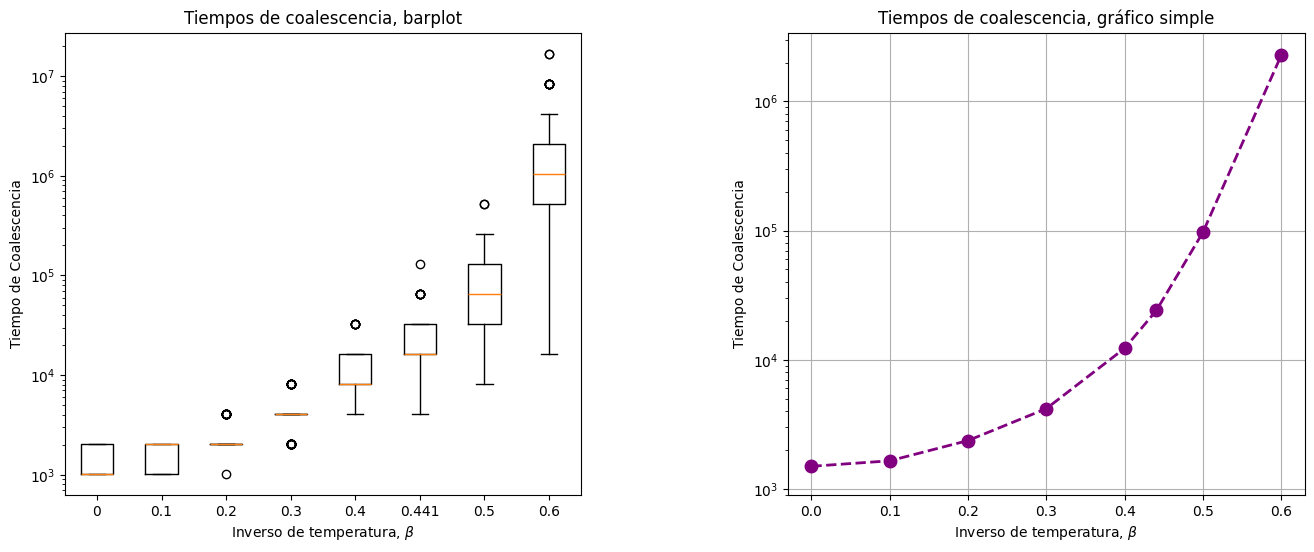

In [21]:
time_avg_list = []
time_std_list = []

for beta in beta_list_pw:
    time_avg_list.append(np.average(tiempos_coalescencia[beta]))
    time_std_list.append(np.std(tiempos_coalescencia[beta]))


## Begin plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)


## Barplot de la izquierda
aux_beta_list_pw = list(beta_list_pw) # Betas de PW aproximados a 3 cifras decimales
for ii, beta in enumerate(aux_beta_list_pw):
    aux_beta_list_pw[ii] = (round(beta, 3))

ax1.set_title('Tiempos de coalescencia, barplot')
ax1.boxplot([tiempos_coalescencia[beta] for beta in beta_list_pw], tick_labels=aux_beta_list_pw)
ax1.set_yscale('log')
ax1.set_xlabel(r'Inverso de temperatura, $\beta$')
ax1.set_ylabel('Tiempo de Coalescencia')


## Gráfico simple de la derecha   
ax2.plot(beta_list_pw, time_avg_list, color='purple', marker='o', linestyle='--', markersize=9, linewidth=2)
ax2.set_title('Tiempos de coalescencia, gráfico simple')
ax2.set_yscale('log')
ax2.set_xlabel(r'Inverso de temperatura, $\beta$')
ax2.set_ylabel('Tiempo de Coalescencia')
ax2.set_ylim([0.9*1E3, np.max(time_avg_list)*1.5])
ax2.grid()


plt.show()

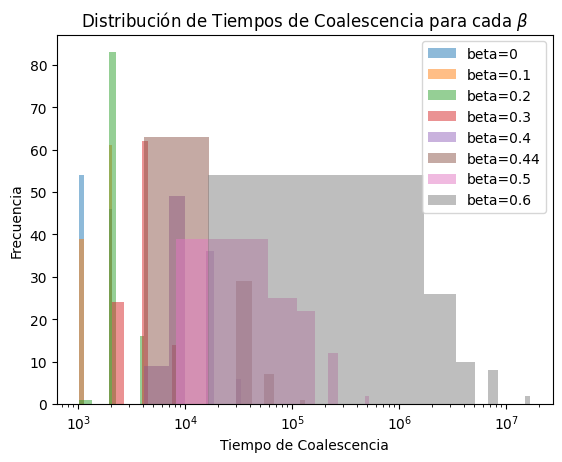

In [27]:
fig, ax = plt.subplots()

for beta, times in tiempos_coalescencia.items():
    ax.hist(times, bins=10, alpha=0.5, label=f'beta={round(beta, 2)}')

ax.set_title(r'Distribución de Tiempos de Coalescencia para cada $\beta$')
ax.set_xlabel('Tiempo de Coalescencia')
ax.set_ylabel('Frecuencia')

ax.set_xscale('log')

ax.legend()

plt.show()

Notamos que el tiempo de coalescencia crece de forma exponencial y aumentan la dispersión en su distribución de frecuencia una vez se supera el valor de $\beta _c$. 

Siguiendo esta tendencia se espera que, por ejemplo, para $\beta = 0.7$ el tiempo de coalescencia sea del orden de $4 \times 10 ^7$. Con esto en mente, y dado que la simulación de $\beta = 0.6$ tomó 23 minutos, se espera que la de $\beta = 0.7$ tome $\sim$ 400 minutos = 6.7 horas.

## Transición de fase

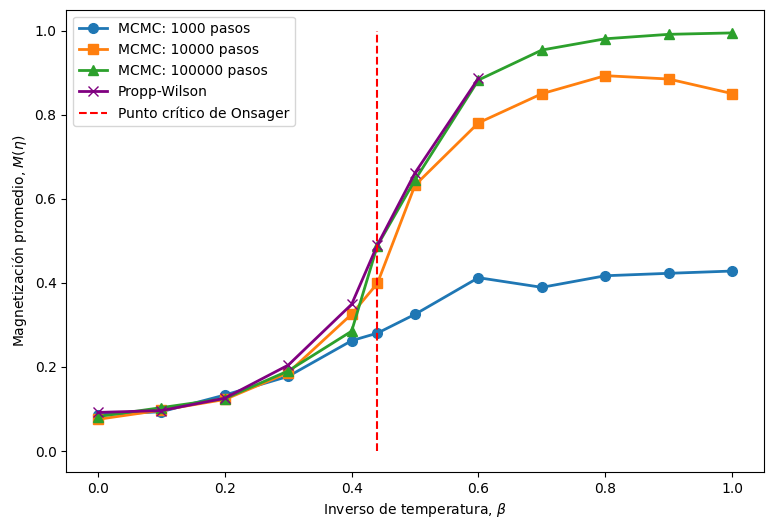

In [28]:
marker_list = ['o', 's', '^', 'd']


plt.figure(figsize=(9, 6))

## Plot de MCMC
for ii, step in enumerate(steps_list):
    magnetizaciones = list(vesperado_mcmc_list[step].values())
    plt.plot(beta_list_mcmcm, magnetizaciones, label=f'MCMC: {step} pasos', marker=marker_list[ii], linestyle='-', markersize=7, linewidth=2)
      

## Plot de Propp-Wilson
plt.plot(beta_list_pw, list(vesperado_pw.values()), label='Propp-Wilson', color='purple', marker='x', linestyle='-', markersize=7, linewidth=2)
    
    
## Onsager critical
plt.vlines(onsager_critical_value, 0, 1, linestyles='dashed', label='Punto crítico de Onsager', color='red')

 
 
## Propiedades de la gráfica
plt.xlabel(r'Inverso de temperatura, $\beta$')
plt.ylabel(r'Magnetización promedio, $M ( \eta ) $')
plt.legend()
#plt.grid()

plt.show()

Una forma comúnmente empleada para identificar transiciones de fase, así como sus características, es graficar la derivada del parámetro [(ver, por ejemplo)](http://micro.stanford.edu/~caiwei/me334/Chap12_Ising_Model_v04.pdf), en la cual se espera un pico muy notorio en el valor crítico donde se da la transición de fase. Así, grafiquemos la derivada numérica de la magnetización del sistema respecto a $\beta$.

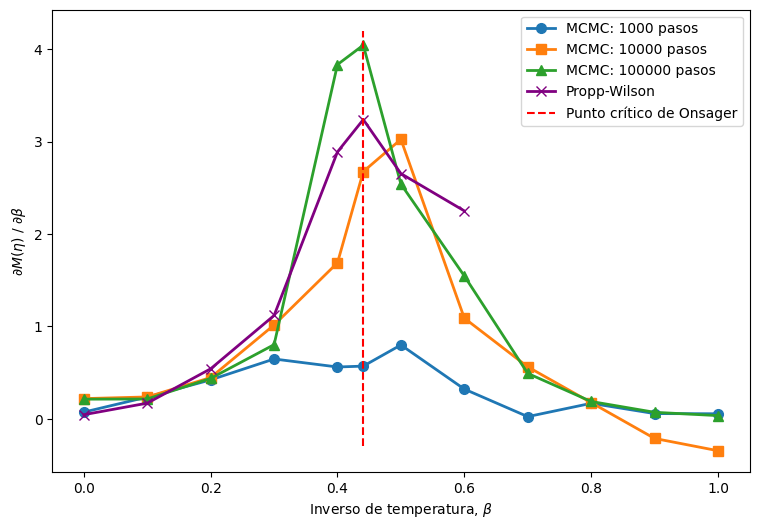

In [36]:
marker_list = ['o', 's', '^', 'd']


plt.figure(figsize=(9, 6))

## Plot de MCMC
for ii, step in enumerate(steps_list):
    x = beta_list_mcmcm
    y = list(vesperado_mcmc_list[step].values())
    dy_dx = np.gradient(y, x)
    
    plt.plot(x, dy_dx, label=f'MCMC: {step} pasos', marker=marker_list[ii], linestyle='-', markersize=7, linewidth=2)
      

## Plot de Propp-Wilson
x = beta_list_pw
y = list(vesperado_pw.values())
dy_dx = np.gradient(y, x)

plt.plot(x, dy_dx, label='Propp-Wilson', color='purple', marker='x', linestyle='-', markersize=7, linewidth=2)
    
    
## Onsager critical
plt.vlines(onsager_critical_value, -0.3, 4.2, linestyles='dashed', label='Punto crítico de Onsager', color='red')

 
 
## Propiedades de la gráfica
plt.xlabel(r'Inverso de temperatura, $\beta$')
plt.ylabel(r'$\partial M ( \eta ) \text{ / }  \partial \beta $')
plt.legend()
#plt.grid()

plt.show()

Finalmente, mencionamos algunas conclusiones:
- El algoritmo de Propp-Wilson con sandwiching, es mucho más computacionalmente eficiente que el algoritmo de Monte Carlo con Metropolis para valores de $\beta \le \beta _c$. Sin embargo, a pesar de permitir muestreo perfecto, decae exponencialmente en términso de eficacia computacional cuando $\beta > \beta _c$.
- Los resultados de la simulación de Monte Carlo con $10^5$ pasos son muy parecidos a los obtenidos con Propp-Wilson, lo que suguiere que este número de pasos provee muestras del sistema similares a los obtenidos con simulación perfecta, es decir, de la distribución estacionaria del sistema.
- La gráfica de la magnetización promedio en función de $\beta$ exhibe indicios de una transición de fase alrededor del punto crítico de Onsager.
- En la gráfica de la derivada de la magnetización respecto a $\beta$ para MCMCM con $10^5$ pasos y Propp-Wilson se oberva un fuerte pico en $\beta _c$, lo que suguiere que la magnetización en el modelo de Ising atraviesa una transición de fase, con valor crítico $\beta_c = \frac{1}{2}\log(1 + \sqrt{2}) \approx 0.441$, el cual coincide con el valor crítico de Onsager.

---
# Simulated Aneealing

Mejor recorrido: [[0.         0.        ]
 [0.13381271 0.07559025]
 [0.18370392 0.03665026]
 [0.35312074 0.06692329]
 [0.75209917 0.07265281]
 [0.53745222 0.12683342]
 [0.730863   0.12570163]
 [0.75594301 0.32287792]
 [0.60678731 0.07049558]
 [0.39895641 0.08585402]
 [0.2628839  0.07249196]
 [0.28056239 0.15472404]
 [0.15746602 0.2805334 ]
 [0.24061812 0.24462974]
 [0.03456659 0.48858693]
 [0.233981   0.78570425]
 [0.15470798 0.91559441]
 [0.10465497 0.81320169]
 [0.31936546 0.92512318]
 [0.37896249 0.70406391]
 [0.33937816 0.74692915]
 [0.40960775 0.69756476]
 [0.94329939 0.8441392 ]
 [0.99677415 0.81054482]
 [0.88914983 0.55241446]
 [0.92180953 0.46759669]
 [0.82119398 0.27363515]
 [0.67921518 0.49801298]
 [0.89893308 0.30308251]
 [0.58691362 0.37335144]
 [0.55366082 0.10833723]
 [0.881702   0.22464644]
 [0.71299769 0.43170503]
 [0.81683198 0.34472775]
 [0.88871026 0.24091014]
 [0.88541366 0.15131931]
 [0.93749301 0.05765701]
 [0.94916593 0.46107779]
 [0.80899694 0.56754334]
 [0.7915

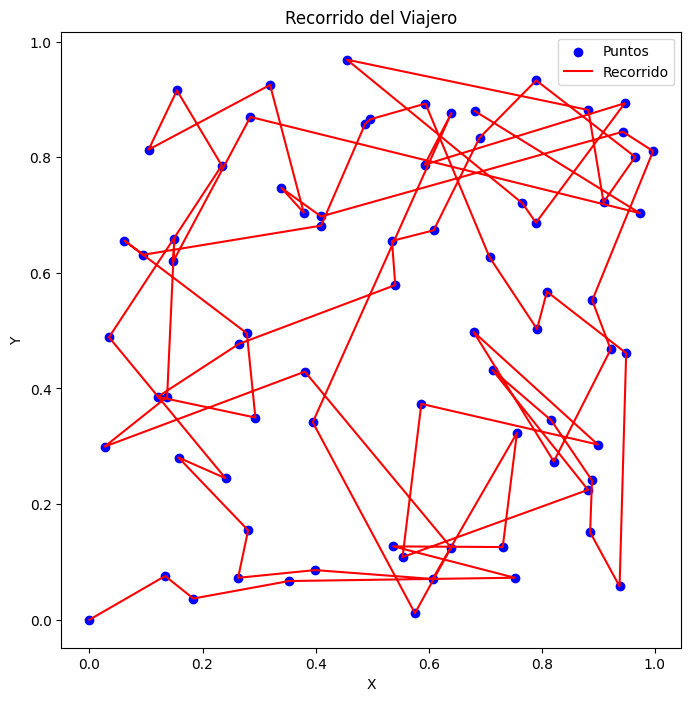

In [205]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

def cargar_puntos_csv(archivo):
    return pd.read_csv(archivo, header=None).values
    
def distancia_puntos(punto_1, punto_2):
    return math.sqrt((punto_1[0] - punto_2[0])**2 + (punto_1[1] - punto_2[1])**2)

def calcular_distancia_total(recorrido):

    total = 0

    for i in range(len(recorrido)-1):
        total += distancia_puntos(recorrido[i], recorrido[i + 1])

    return total

def calcular_aceptacion(mejor_distancia, distancia, temp):
    return np.exp((mejor_distancia-distancia)/temp) # -(f(x) - f(y)) = - (f(candidato) - f(actual)) = f(actual) - f(candidato)

def recorrido_aleatorio(puntos):
    recorrido = list(range(1, len(puntos)))  # Excluir el punto (0,0) del shuffle
    random.shuffle(recorrido)
    recorrido.insert(0, 0)  # Agregar el punto (0,0) al inicio
    return np.array([puntos[x] for x in recorrido])

def simulated_annealing(puntos, t_inicial, temp_final, enfriamiento, iteraciones):
    recorrido = recorrido_aleatorio(puntos)
    mejor_distancia = calcular_distancia_total(recorrido) # cost0
    #print(recorrido)

    temp = t_inicial

    while temp > temp_final:

        for _ in range(iteraciones):

            i, j = np.random.randint(1, len(recorrido), size=2)

            aux = deepcopy(recorrido[i])
            recorrido[i] = recorrido[j]
            recorrido[j] = aux
            
            nueva_distancia = calcular_distancia_total(recorrido)
            
            if nueva_distancia < mejor_distancia:
                mejor_distancia = nueva_distancia
            else: 
                if np.random.rand() < calcular_aceptacion(mejor_distancia, nueva_distancia, temp):
                    mejor_distancia = nueva_distancia
                else:
                    aux = deepcopy(recorrido[i])
                    recorrido[i] = recorrido[j]
                    recorrido[j] = aux
            
        temp *= enfriamiento
    return recorrido, mejor_distancia 

data = cargar_puntos_csv("data.csv")

temp_inicial = 10000
temp_final = 0.1
enfriamiento = 0.99

iteraciones = 1000

recorrido, distancia = simulated_annealing(data, temp_inicial, temp_final, enfriamiento, iteraciones)

print("Mejor recorrido:", recorrido)
print("Distancia total:", distancia)

# Graficar el recorrido
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Puntos')
plt.plot(recorrido[[x for x in range(len(data))], 0], recorrido[[x for x in range(len(data))], 1], color='red', label='Recorrido')
plt.title('Recorrido del Viajero')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()